# SYSID - Trabalho (ML - MISO.LM)

Alunos: 

Pedro Henrique Cardoso Paulo</br>
Felipe da Costa Pereira

Professor: Helon

## Objetivo

TBD

## Passo 0 - Importando bibliotecas

In [1]:
# Pacotes padrao
import os
import pickle
import copy
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

#Pipeline
from sklearn.pipeline import Pipeline

#Tratamento
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#Modelos
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor

#sisidentpy
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.narmax_tools import regressor_code

#Busca de modelos
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold

# Scores
from sklearn.metrics import r2_score

# Disabling warnings
import warnings
from sklearn.exceptions import DataConversionWarning

#Definindo random_state
rs = 85

In [2]:
import sys
sys.path.insert(0, os.path.abspath('..'))
from sklearn_sid.regressors.sklearn import SYSIDRegressor

## Passo 0 - Importando os dados

### 0.1 - Lendo dados

In [3]:
binary = os.path.join(os.getcwd(), 'data', 'volve_compiled.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    data = pickle.load(bin_file)

/mnt/d/sklearn-sid/Volve-Dataset/data/volve_compiled.pkl


In [4]:
for wellp in data['OP'].keys():
    print(wellp)

15/9-F-1 C
15/9-F-11
15/9-F-12
15/9-F-14
15/9-F-15 D
15/9-F-5


### 0.2 - Visualizando dados

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


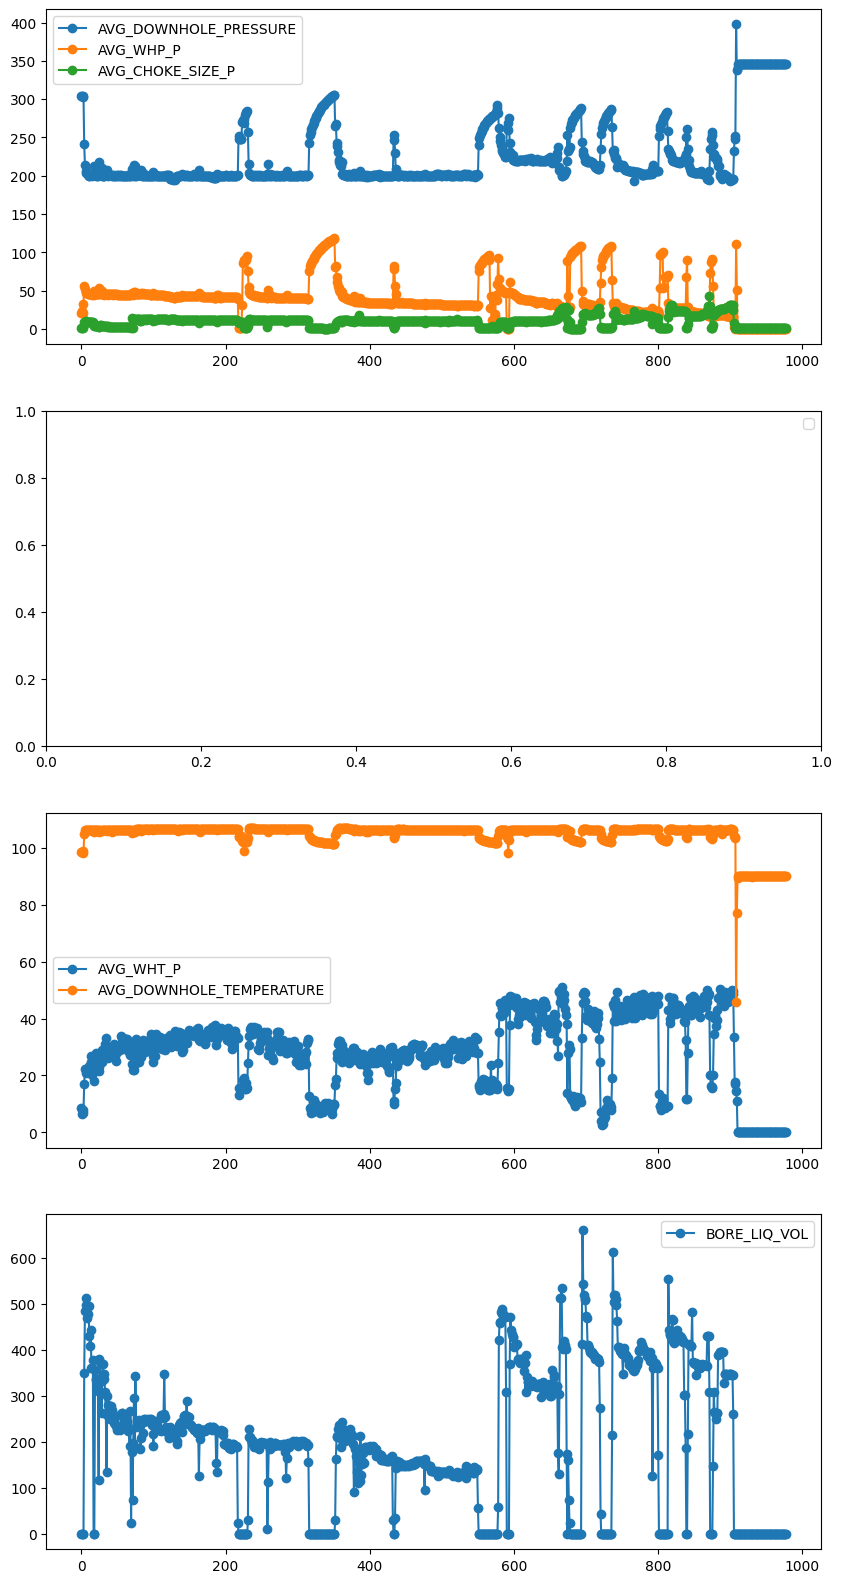

In [5]:
case = "15/9-F-15 D"
#case = "15/9-F-11"

data_case = data['OP'][case]

filt_vars_IN_Q =  [
        #'BORE_OIL_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
        #'BORE_OIL_CUM',
        #'BORE_LIQ_CUM',
        #'BORE_GAS_CUM',
        #'BORE_WAT_CUM',
]

filt_vars_IN_QINJ = [
        'BORE_WI_VOL',
        'BORE_WI_CUM',
]

filt_vars_IN_P = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        #'AVG_DP_TUBING',
        #'AVG_ANNULUS_PRESS',
        'AVG_CHOKE_SIZE_P',
        #'DP_CHOKE_SIZE',
]

filt_vars_IN_T = [
        'AVG_WHT_P',
        'AVG_DOWNHOLE_TEMPERATURE',
]

filt_vars_OUT = [
        #'BORE_OIL_VOL',
        'BORE_LIQ_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
]

time = data_case['N']
fig, ax = plt.subplots(4,1, figsize=(10, 20))
for var in filt_vars_IN_P:
    ax[0].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_Q:
    ax[1].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_T:
    ax[2].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_OUT:
    ax[3].plot(time, data_case[var], '-o', label=var)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

In [6]:
data_case = data_case.iloc[28:-200,:]
#data_case = data_case[data_case['AVG_DOWNHOLE_PRESSURE']>0]
data_case = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T + filt_vars_OUT].dropna()
X1 = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T].values
y =  data_case[filt_vars_OUT].values

## Passo 1 - Separando os dados em treino e teste

### 1.1 - Definindo a parcela de treino e de teste

In [7]:
p_train = 0.7 #70% treino

### 1.2 - Separando os conjuntos

In [8]:
n_train = int(X1.shape[0]*p_train)
X1_tr = X1[:n_train,:]
y_tr = y[:n_train,:]
X1_te = X1[:,:]
y_te = y[:,:]

In [9]:
print(
    X1_tr.shape,
    X1_te.shape
)

(525, 5) (750, 5)


### 1.3 - Removendo a escala 

In [10]:
X_scale = MinMaxScaler()
y_scale = MinMaxScaler()
X_tr = X_scale.fit_transform(X1_tr)
X_te = X_scale.transform(X1_te)
y_tr = y_scale.fit_transform(y_tr)
y_te = y_scale.transform(y_te)

## Passo 2 - Declarando os modelos 

In [11]:
models = []

### 2.1 - ARMAX (sysidentpy)

In [12]:
basis_function = Polynomial(degree=1)
n = 2
na = n
nb = [n] * X1.shape[1]
ne = 1
n_terms = 6
model = FROLS(
    order_selection=True,
    ylag=na, xlag=nb,elag=ne,
    basis_function=basis_function,
    n_info_values=100,
    #n_terms=n_terms,
    model_type='NARMAX',
    #extended_least_squares=True,
)

models.append(('ARMAX', model))

### 2.2 - NARMAX (sysidentpy)

In [13]:
basis_function = Fourier(degree=2)
n = 2
na = n
nb = [n] * X1.shape[1]
ne = 1
n_terms = 6
model = FROLS(
    order_selection=True,
    ylag=na, xlag=nb,elag=ne,
    basis_function=basis_function,
    n_info_values=100,
    #n_terms=n_terms,
    model_type='NARMAX',
    #extended_least_squares=True,
)
models.append(('NARMAX', model))

### 2.3 - Modelos de ML (sklearn)

#### 2.3.1 - Modelos

In [14]:
models_ml = [
    ('LinReg'          ,      LinearRegression(copy_X=True)), #ARX Equivalent
    ('PolyReg'         ,      Pipeline([('Poly', PolynomialFeatures(degree=2)), ('Reg', LinearRegression(copy_X=True))])), #NARX Equivalent
    ('SVM'             ,      SVR(max_iter=-1)),
    ('KNN'             ,      KNeighborsRegressor()),
    ('DecisionTree'    ,      DecisionTreeRegressor(random_state=rs)),
    ('RandomForest'    ,      RandomForestRegressor(random_state=rs)),
    ('GradientBoosting',      GradientBoostingRegressor(random_state=rs)),
    ('ExtraTrees'      ,      ExtraTreesRegressor(random_state=rs)),
    ('MLP'             ,      MLPRegressor(random_state=rs, )),
]

#### 2.3.2 - Parâmetros (RandomSearchCV)

In [15]:
parameters = [
    {
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'positive'                     : [True, False],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'Reg__positive'                : [True, False],
        #'Poly__degree'                : [2, 3, 4, 5],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'C'                     : stats.loguniform(1e-3, 1e3),
        'kernel'                : ['poly', 'rbf', 'sigmoid','linear'],
        'degree'                : stats.randint(2,6),
        'gamma'                 : stats.loguniform(1e-4, 1e0),
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_neighbors'           : stats.randint(1,100),
        'weights'               : ['uniform', 'distance'],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        #'DT__criterion'              : ['gini', 'entropy'],
        'splitter'               : ['best', 'random'],
        'max_depth'              : stats.randint(5,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        'loss'                   : ['squared_error', 'absolute_error', 'huber', 'quantile'],
        'learning_rate'          : stats.loguniform(1e-5, 1e1),
        'criterion'              : ['friedman_mse', 'squared_error'],
        'subsample'              : stats.uniform(), 
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        'criterion'              : ['squared_error', 'absolute_error'],
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    #{
    #    'activation'            : ['relu', 'logistic', 'tanh'],
    #    'early_stopping'        : [True, False],
    #    'alpha'                 : stats.loguniform(1e-9, 1e0),
    #    'hidden_layer_sizes'    : [(100,), (100, 100,), (100, 100, 100,), (100, 100, 100, 100,)],
    #    'max_iter'              : [10000],#stats.randint(200,10000),
    #    'batch_size'            : [32, 64, 128, 256, 'auto'],
    #    'solver'                : ['adam'], #'lbfgs'],
    #    'tol'                   : stats.loguniform(1e-7, 1e-1),
    #},
    {
        'activation'            : ['relu'], #'logistic', 'tanh'],
        'early_stopping'        : [True, False],
        'alpha'                 : stats.loguniform(1e-4, 1e0),
        'hidden_layer_sizes'    : [] 
        + [n_neurons for n_neurons in itertools.product([20, 40, 60, 80, 100], repeat=1)]
        + [n_neurons for n_neurons in itertools.product([20, 40, 60, 80, 100], repeat=2)]
        + [n_neurons for n_neurons in itertools.product([20, 40, 60, 80, 100], repeat=3)]
        + [n_neurons for n_neurons in itertools.product([20, 40, 60, 80, 100], repeat=4)],
        'max_iter'              : [10000],#stats.randint(200,10000),
        'batch_size'            : [16, 32, 64, 128, 256],
        'solver'                : ['adam'], #'lbfgs'],
        'tol'                   : stats.loguniform(1e-7, 1e-1),

    },
]

In [16]:
kfolds = 5
niters = 10
rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)

In [17]:
n_iter = 100 #Numero de iterações do rdmsearch 

for model, params in zip(models_ml, parameters):
    rdmsearch = RandomizedSearchCV(model[1], verbose=0, scoring='r2', 
                                   param_distributions=params, n_iter=n_iter, n_jobs=6, 
                                   cv=rkf, random_state=rs)
    
    sidmodel = SYSIDRegressor(
        nX=6, ny=6,
        estimator=rdmsearch, 
        preprocessor=MinMaxScaler(),
        #expansor=PolynomialFeatures(degree=2)
        )
    
    models.append(
        (model[0], sidmodel)
    )

#models = models[-1:]


In [18]:
n_models = len(models)

results = {
    'MODEL':[],
    'ORDER':[],
    'R2 TRAIN OSA':[],
    'R2 TEST OSA':[],
    'R2 TRAIN FS':[],
    'R2 TEST FS':[],
    'MODEL OBJ':[],
    'PARS':[]
}

order_progression = {
    'MODEL':[],
    'ORDER':[],
    'R2 TRAIN OSA':[],
    'R2 TEST OSA':[],
    'R2 TRAIN FS':[],
    'R2 TEST FS':[],
    'MODEL OBJ':[],
}

In [19]:
for model in models:
    print(model[0])

ARMAX
NARMAX
LinReg
PolyReg
SVM
KNN
DecisionTree
RandomForest
GradientBoosting
ExtraTrees
MLP


In [20]:

#fig, axs = plt.subplots(ncols=2, nrows=n_models, figsize=(25,n_models*7))
orders = range(2,21)
prefix = 'MISO.W2'
#Loop principal, iterando sobre as listas
for model in models[2:]:
    
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,7))

    model_name, sidmodel = model

    print('Starting evaluation of model: {}'.format(model_name))
    
    t0 = datetime.now()

    best_r2_tr_fs = 1e6
    best_r2_te_fs = 1e6
    best_r2_tr_osa = 1e6
    best_r2_te_osa = 1e6
    best_order = 0
    best_model = sidmodel
    
    for order in orders:
        print(f'    Trying order: {order}')
        if hasattr(sidmodel, 'nX'): # is from our package
            sidmodel.nX = order
            sidmodel.ny = order
        else:
            sidmodel.xlag = [order]*X1_tr.shape[1]
            sidmodel.ylag = order
            sidmodel.elag = order
            regressors = regressor_code(X=X1_tr,
                                        xlag=[order]*X1_tr.shape[1],
                                        ylag=order,
                                        model_type="NARMAX",
                                        model_representation="neural_network",
                                        basis_function=sidmodel.basis_function
                                        )

            n_features = regressors.shape[0]
            
            #sidmodel.n_terms = n_features

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sidmodel.fit(X=X1_tr, y=y_tr)
        r2_tr_osa = r2_score(y_tr, sidmodel.predict(X1_tr, y=y_tr, steps_ahead=1))
        r2_te_osa = r2_score(y_te, sidmodel.predict(X1_te, y=y_te, steps_ahead=1))
        try:
            r2_tr_fs = r2_score(y_tr, sidmodel.predict(X1_tr, y=y_tr))
            r2_te_fs = r2_score(y_te, sidmodel.predict(X1_te, y=y_te))
        except ValueError:
            r2_tr_fs = 1e290
            r2_te_fs = 1e290
        if np.abs(r2_tr_fs - 1) < np.abs(best_r2_tr_fs - 1):
            best_r2_tr_fs = r2_tr_fs
            best_r2_te_fs = r2_te_fs
            best_r2_tr_osa = r2_tr_osa
            best_r2_te_osa = r2_te_osa
            best_order = order
            best_model = copy.deepcopy(sidmodel)
        order_progression['MODEL'].append(model_name)
        order_progression['ORDER'].append(order)
        order_progression['R2 TRAIN OSA'].append(r2_tr_osa)
        order_progression['R2 TEST OSA'].append(r2_te_osa)
        order_progression['R2 TRAIN FS'].append(r2_tr_fs)
        order_progression['R2 TEST FS'].append(r2_te_fs)
        order_progression['MODEL OBJ'].append(copy.deepcopy(sidmodel))
        print('        R2 score OSA (Train):', r2_tr_osa)
        print('        R2 score OSA (Test):', r2_te_osa)
        print('        R2 score FS (Train):', r2_tr_fs)
        print('        R2 score FS (Test):', r2_te_fs)
    print()
    print('    Tempo de execução: {}'.format(datetime.now() - t0))
    print('    Best Order:', best_order)
    print('    R2 score OSA (Train):', best_r2_tr_osa)
    print('    R2 score OSA (Test):', best_r2_te_osa)
    print('    R2 score FS (Train):', best_r2_tr_fs)
    print('    R2 score FS (Test):', best_r2_te_fs)

    hist = ax[0].plot(y_tr, label='Train')
    hist = ax[0].plot(best_model.predict(X1_tr, y=y_tr), label='Model') 
    ax[0].set_title(f'Train fit')
    ax[0].legend()
    hist = ax[1].plot(y_te[n_train:,:], label='Test')
    hist = ax[1].plot(best_model.predict(X1_te, y=y_te)[n_train:,:], label='Model')
    ax[1].set_title(f'Test prediction')
    ax[1].legend()
    fig.suptitle(f'{model_name} ({case})')
    fig.savefig(os.path.join(os.getcwd(),'outputs', 'test_runs',f'{prefix}_{model_name}.pdf'))
    print()
    
    results['MODEL'].append(model_name) 
    results['ORDER'].append(best_order)
    results['R2 TRAIN OSA'].append(best_r2_tr_osa)
    results['R2 TEST OSA'].append(best_r2_te_osa)
    results['R2 TRAIN FS'].append(best_r2_tr_fs)
    results['R2 TEST FS'].append(best_r2_te_fs) 
    results['MODEL OBJ'].append(best_model)
    try:
        results['PARS'].append(best_model.estimator.best_params_)
    except Exception:
        results['PARS'].append(best_model.final_model)

Starting evaluation of model: LinReg
    Trying order: 2
        R2 score OSA (Train): 0.8295015398656436
        R2 score OSA (Test): 0.8377062657536631
        R2 score FS (Train): 0.48131219671737213
        R2 score FS (Test): 0.05101854255535798
    Trying order: 3
        R2 score OSA (Train): 0.8325983519339232
        R2 score OSA (Test): 0.8378184854840607
        R2 score FS (Train): 0.5032604486687065
        R2 score FS (Test): 0.14271246873134402
    Trying order: 4
        R2 score OSA (Train): 0.8332945306192739
        R2 score OSA (Test): 0.8381628114280808
        R2 score FS (Train): 0.5102162053234294
        R2 score FS (Test): 0.21004796414739801
    Trying order: 5
        R2 score OSA (Train): 0.8358125411572004
        R2 score OSA (Test): 0.8387004213666582
        R2 score FS (Train): 0.5174400428534149
        R2 score FS (Test): 0.22815651111536828
    Trying order: 6
        R2 score OSA (Train): 0.8360952892920982
        R2 score OSA (Test): 0.8386693020

/home/c5ef-linux/miniconda3/envs/sklearn-sid/lib/python3.11/site-packages/sklearn/preprocessing/_polynomial.py:440: RuntimeWarning: overflow encountered in multiply
  np.multiply(


        R2 score OSA (Train): 0.8438665632714768
        R2 score OSA (Test): 0.8352333216494616
        R2 score FS (Train): 1e+290
        R2 score FS (Test): 1e+290
    Trying order: 4


/home/c5ef-linux/miniconda3/envs/sklearn-sid/lib/python3.11/site-packages/sklearn/preprocessing/_polynomial.py:440: RuntimeWarning: overflow encountered in multiply
  np.multiply(


        R2 score OSA (Train): 0.8450413438934072
        R2 score OSA (Test): 0.8356488507907277
        R2 score FS (Train): 1e+290
        R2 score FS (Test): 1e+290
    Trying order: 5
        R2 score OSA (Train): 0.8472369435061305
        R2 score OSA (Test): 0.8376877823939606
        R2 score FS (Train): 0.5432812974361286
        R2 score FS (Test): 0.09539168821998445
    Trying order: 6
        R2 score OSA (Train): 0.8479433917225331
        R2 score OSA (Test): 0.8377934413625951
        R2 score FS (Train): 0.4730357817681542
        R2 score FS (Test): -0.006765932175317291
    Trying order: 7


/home/c5ef-linux/miniconda3/envs/sklearn-sid/lib/python3.11/site-packages/sklearn/preprocessing/_polynomial.py:440: RuntimeWarning: overflow encountered in multiply
  np.multiply(


        R2 score OSA (Train): 0.8507863779352169
        R2 score OSA (Test): 0.8052579965863081
        R2 score FS (Train): 1e+290
        R2 score FS (Test): 1e+290
    Trying order: 8


/home/c5ef-linux/miniconda3/envs/sklearn-sid/lib/python3.11/site-packages/sklearn/preprocessing/_polynomial.py:440: RuntimeWarning: overflow encountered in multiply
  np.multiply(


        R2 score OSA (Train): 0.8582481489576973
        R2 score OSA (Test): 0.7585935806692502
        R2 score FS (Train): 1e+290
        R2 score FS (Test): 1e+290
    Trying order: 9


/home/c5ef-linux/miniconda3/envs/sklearn-sid/lib/python3.11/site-packages/sklearn/preprocessing/_polynomial.py:440: RuntimeWarning: overflow encountered in multiply
  np.multiply(


        R2 score OSA (Train): 0.8621792866129137
        R2 score OSA (Test): 0.7926217816628143
        R2 score FS (Train): 1e+290
        R2 score FS (Test): 1e+290
    Trying order: 10


/home/c5ef-linux/miniconda3/envs/sklearn-sid/lib/python3.11/site-packages/sklearn/preprocessing/_polynomial.py:440: RuntimeWarning: overflow encountered in multiply
  np.multiply(


        R2 score OSA (Train): 0.8638247897502777
        R2 score OSA (Test): 0.7758403064761152
        R2 score FS (Train): 1e+290
        R2 score FS (Test): 1e+290
    Trying order: 11


/home/c5ef-linux/miniconda3/envs/sklearn-sid/lib/python3.11/site-packages/sklearn/preprocessing/_polynomial.py:440: RuntimeWarning: overflow encountered in multiply
  np.multiply(


        R2 score OSA (Train): 0.8648417920361529
        R2 score OSA (Test): 0.7665733614516201
        R2 score FS (Train): 1e+290
        R2 score FS (Test): 1e+290
    Trying order: 12


/home/c5ef-linux/miniconda3/envs/sklearn-sid/lib/python3.11/site-packages/sklearn/preprocessing/_polynomial.py:440: RuntimeWarning: overflow encountered in multiply
  np.multiply(


        R2 score OSA (Train): 0.86556653986137
        R2 score OSA (Test): 0.7547438833692932
        R2 score FS (Train): 1e+290
        R2 score FS (Test): 1e+290
    Trying order: 13


/home/c5ef-linux/miniconda3/envs/sklearn-sid/lib/python3.11/site-packages/sklearn/preprocessing/_polynomial.py:440: RuntimeWarning: overflow encountered in multiply
  np.multiply(


        R2 score OSA (Train): 0.8665489678166773
        R2 score OSA (Test): 0.7330227874116182
        R2 score FS (Train): 1e+290
        R2 score FS (Test): 1e+290
    Trying order: 14


/home/c5ef-linux/miniconda3/envs/sklearn-sid/lib/python3.11/site-packages/sklearn/preprocessing/_polynomial.py:440: RuntimeWarning: overflow encountered in multiply
  np.multiply(


        R2 score OSA (Train): 0.8674155575213426
        R2 score OSA (Test): 0.7187822667095516
        R2 score FS (Train): 1e+290
        R2 score FS (Test): 1e+290
    Trying order: 15


/home/c5ef-linux/miniconda3/envs/sklearn-sid/lib/python3.11/site-packages/sklearn/preprocessing/_polynomial.py:440: RuntimeWarning: overflow encountered in multiply
  np.multiply(


        R2 score OSA (Train): 0.868607017090097
        R2 score OSA (Test): 0.6803424470196481
        R2 score FS (Train): 1e+290
        R2 score FS (Test): 1e+290
    Trying order: 16


/home/c5ef-linux/miniconda3/envs/sklearn-sid/lib/python3.11/site-packages/sklearn/preprocessing/_polynomial.py:440: RuntimeWarning: overflow encountered in multiply
  np.multiply(


        R2 score OSA (Train): 0.8691234012229777
        R2 score OSA (Test): 0.6655716636197411
        R2 score FS (Train): 1e+290
        R2 score FS (Test): 1e+290
    Trying order: 17


/home/c5ef-linux/miniconda3/envs/sklearn-sid/lib/python3.11/site-packages/sklearn/preprocessing/_polynomial.py:440: RuntimeWarning: overflow encountered in multiply
  np.multiply(


        R2 score OSA (Train): 0.8699085625217919
        R2 score OSA (Test): 0.646136783631526
        R2 score FS (Train): 1e+290
        R2 score FS (Test): 1e+290
    Trying order: 18


/home/c5ef-linux/miniconda3/envs/sklearn-sid/lib/python3.11/site-packages/sklearn/preprocessing/_polynomial.py:440: RuntimeWarning: overflow encountered in multiply
  np.multiply(


        R2 score OSA (Train): 0.8702241773081713
        R2 score OSA (Test): 0.6359509849838618
        R2 score FS (Train): 1e+290
        R2 score FS (Test): 1e+290
    Trying order: 19


/home/c5ef-linux/miniconda3/envs/sklearn-sid/lib/python3.11/site-packages/sklearn/preprocessing/_polynomial.py:440: RuntimeWarning: overflow encountered in multiply
  np.multiply(


        R2 score OSA (Train): 0.8704634129606523
        R2 score OSA (Test): 0.63299953988275
        R2 score FS (Train): 1e+290
        R2 score FS (Test): 1e+290
    Trying order: 20


/home/c5ef-linux/miniconda3/envs/sklearn-sid/lib/python3.11/site-packages/sklearn/preprocessing/_polynomial.py:440: RuntimeWarning: overflow encountered in multiply
  np.multiply(


        R2 score OSA (Train): 0.8706922135363431
        R2 score OSA (Test): 0.6291315742599954
        R2 score FS (Train): 1e+290
        R2 score FS (Test): 1e+290

    Tempo de execução: 0:01:47.297850
    Best Order: 2
    R2 score OSA (Train): 0.8411333110780348
    R2 score OSA (Test): 0.8412513785037379
    R2 score FS (Train): 0.5895004061614284
    R2 score FS (Test): 0.13630655912186584

Starting evaluation of model: SVM
    Trying order: 2
        R2 score OSA (Train): 0.8247800807528469
        R2 score OSA (Test): 0.6755495812572825
        R2 score FS (Train): 0.5067217526813218
        R2 score FS (Test): -0.17618715126888618
    Trying order: 3
        R2 score OSA (Train): 0.8261908796066469
        R2 score OSA (Test): 0.7991637581111538
        R2 score FS (Train): 0.5710424636750013
        R2 score FS (Test): -0.1490431714230227
    Trying order: 4
        R2 score OSA (Train): 0.8197735300058946
        R2 score OSA (Test): 0.7364699597281054
        R2 score FS

In [ ]:
pd.DataFrame(results)

,MODEL,ORDER,R2 TRAIN OSA,R2 TEST OSA,R2 TRAIN FS,R2 TEST FS,MODEL OBJ,PARS
0,ARMAX,3,0.805077,0.853349,-3.390653,-2.077438,<sysidentpy.model_structure_selection.forward_...,[[1001]]
1,NARMAX,20,0.822281,0.796657,-1.111255,-0.886904,<sysidentpy.model_structure_selection.forward_...,"[[6013, 1002]]"
2,LinReg,20,0.853093,0.832511,0.562877,0.325709,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,{'positive': True}
3,PolyReg,2,0.841133,0.841251,0.589500,0.136307,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,{'Reg__positive': True}
4,SVM,3,0.826191,0.799164,0.571042,-0.149043,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'C': 350.2775989932839, 'degree': 2, 'gamma':..."
5,KNN,18,1.000000,0.398024,0.845899,0.249559,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'n_neighbors': 3, 'weights': 'distance'}"
6,DecisionTree,13,0.890495,0.584348,0.610675,0.043119,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'max_depth': 15, 'max_features': 0.1869351354..."
7,RandomForest,14,0.964238,0.359251,0.677141,-0.226112,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'max_depth': 15, 'max_features': 0.4813329840..."
8,GradientBoosting,5,0.911423,0.470437,0.725594,0.076703,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'criterion': 'squared_error', 'learning_rate'..."
9,ExtraTrees,18,0.976830,0.346875,0.739934,0.016620,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'criterion': 'squared_error', 'max_depth': 14..."


In [ ]:
order_progression = pd.DataFrame(order_progression)
order_progression

,MODEL,ORDER,R2 TRAIN OSA,R2 TEST OSA,R2 TRAIN FS,R2 TEST FS,MODEL OBJ
0,ARMAX,2,0.804456,0.853199,-3.489049,-2.101239,<sysidentpy.model_structure_selection.forward_...
1,ARMAX,3,0.805077,0.853349,-3.390653,-2.077438,<sysidentpy.model_structure_selection.forward_...
2,ARMAX,4,0.805151,0.853367,-3.421574,-2.084918,<sysidentpy.model_structure_selection.forward_...
3,ARMAX,5,0.805154,0.853367,-3.428770,-2.086658,<sysidentpy.model_structure_selection.forward_...
4,ARMAX,6,0.805341,0.853412,-3.489001,-2.101228,<sysidentpy.model_structure_selection.forward_...
...,...,...,...,...,...,...,...
204,MLP,16,0.866923,0.625924,0.620638,-0.180216,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
205,MLP,17,0.879214,0.600088,0.620278,0.044196,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
206,MLP,18,0.889859,0.646397,0.354702,0.084870,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
207,MLP,19,0.888702,0.542479,0.543710,-0.323198,SYSIDRegressor(estimator=RandomizedSearchCV(cv...


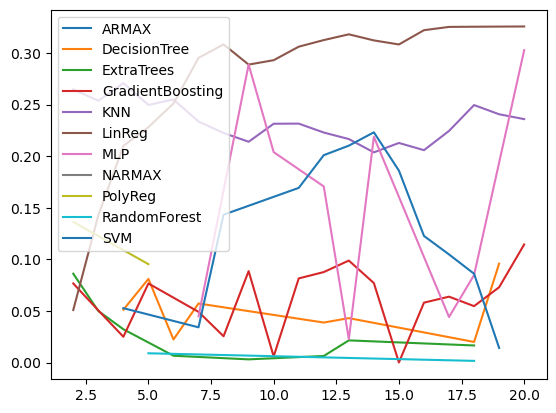

In [ ]:
fig, ax = plt.subplots()
for model in np.unique(order_progression.MODEL):
    #if model == 'DT': continue
    data_filt = order_progression[order_progression.MODEL == model]
    data_filt = data_filt[(data_filt['R2 TEST FS'] >= 0)&(data_filt['R2 TEST FS'] <= 2)]
    ax.plot(data_filt.ORDER, data_filt['R2 TEST FS'], label=model)
ax.legend()

In [ ]:

binary = os.path.join(os.getcwd(), 'outputs', 'test_runs', f'{prefix}_ml.pkl')
print(binary)

with open(binary, 'wb') as bin_file:
    pickle.dump((X1_tr, y_tr, X1_te, y_te, results, order_progression), bin_file)

/mnt/d/OneDrive/Mestrado/Semestre 02/SYSID/SYSID_Trabalho/Volve-Dataset/outputs/MISO.W2_ml.pkl


In [ ]:
print(results['PARS'][-1])

{'activation': 'relu', 'alpha': 0.004272522586637966, 'batch_size': 16, 'early_stopping': True, 'hidden_layer_sizes': (100, 100, 20, 20), 'max_iter': 10000, 'solver': 'adam', 'tol': 3.771767182519592e-06}
